In [1]:
import sys
!{sys.executable} -m pip install textblob

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import nltk
import string
import pickle

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from textblob import TextBlob 
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/unheard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/unheard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/unheard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read dataset for fraudulent emails

In [4]:
df = pd.read_csv("fraud_email_.csv")
df.rename(columns={"Text": "Email"}, inplace=True)
df

,Email,Class
0,Supply Quality China's EXCLUSIVE dimensions at...,1
1,over. SidLet me know. Thx.,0
2,"Dear Friend,Greetings to you.I wish to accost ...",1
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1
4,Not a surprising assessment from Embassy.,0
...,...,...
11924,Travel well. I'll look forward to hearing your...,0
11925,"Dear friend, I wish to begin by way of introdu...",1
11926,Follow Up Flag: Follow upFlag Status: FlaggedM...,0
11927,sbwhoeop B6Saturday January 23 2010 4:09 PMRe:...,0


# Remove punctuation

We need to remove the punctuation so that TextBlob can tokenise each word correctly.

E.g. \
"Hello world" -> ["Hello", "world"] \
"Hello world!" -> ["Hello", "world!"]

TextBlob will recognise "world" and "world!" as two separate models

In [5]:
def convert_to_text_blob(text):
    text = str(text).lower()
    text = text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    return TextBlob(text)

df["Email"] = df["Email"].map(convert_to_text_blob)

df

,Email,Class
0,"(s, u, p, p, l, y, , q, u, a, l, i, t, y, , ...",1
1,"(o, v, e, r, , , s, i, d, l, e, t, , m, e, ...",0
2,"(d, e, a, r, , f, r, i, e, n, d, , g, r, e, ...",1
3,"(m, r, , , c, h, e, u, n, g, , p, u, i, h, ...",1
4,"(n, o, t, , a, , s, u, r, p, r, i, s, i, n, ...",0
...,...,...
11924,"(t, r, a, v, e, l, , w, e, l, l, , , i, , ...",0
11925,"(d, e, a, r, , f, r, i, e, n, d, , , i, , ...",1
11926,"(f, o, l, l, o, w, , u, p, , f, l, a, g, , ...",0
11927,"(s, b, w, h, o, e, o, p, , b, 6, s, a, t, u, ...",0


## Stemming

In [6]:
df["Email"] = df["Email"].map(lambda x: x.words)

### Remove stopwords

In order to reduce processing and to remove words that are commonly used in the english language

In [7]:
def remove_stopwords(word_list):
    stopword_free_list = [word for word in word_list if word not in stopwords.words("english")]
    return stopword_free_list

df["Email"] = df["Email"].map(remove_stopwords)

### Stem the words and join into a string

In [8]:
def stem_words(word_list):
    stemmed_words = []
    for word in word_list:
        stemmed_words.append(word.stem())

    return " ".join(stemmed_words)

df["Email"] = df["Email"].map(stem_words)

df

,Email,Class
0,suppli qualiti china exclus dimens unbeat pric...,1
1,sidlet know thx,0
2,dear friend greet wish accost request would im...,1
3,mr cheung puihang seng bank ltd de voeux rd br...,1
4,surpris assess embassi,0
...,...,...
11924,travel well look forward hear report,0
11925,dear friend wish begin way introduct william m...,1
11926,follow flag follow upflag statu flaggedmor info,0
11927,sbwhoeop b6saturday januari 23 2010 4 09 pmre ...,0


# Creating the machine learning model

### First convert our text using TfidfVectorizer to count the frequency of each word in an email.

In [9]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

x = vectorizer.fit_transform(df["Email"]).toarray()
y = df["Class"]

### Split the dataset into a training and test set

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Create a random forrest classifier to train our model on

In [11]:
rf_classifier = RandomForestClassifier()

rf_classifier.fit(x_train, y_train)

RandomForestClassifier()

### Use the Random Forest Classifier to predict the test data

We also find the confusion matrix and compute the accuracy to determine how well our model performs

Accuracy: 0.9911986588432523


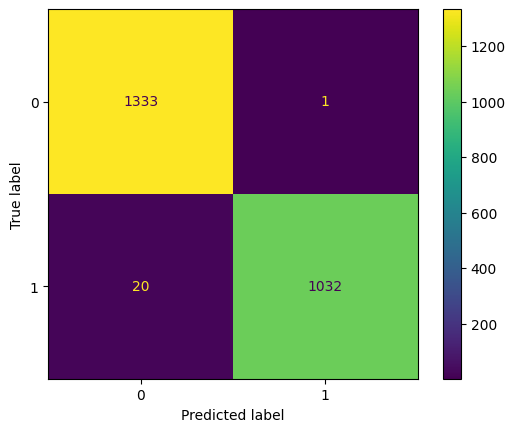

In [12]:
y_pred = rf_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

# Creating an interface for using the model

### Saving the model and vectorizer for future use
From our test data, the model has a very high accuracy, so we will save the model so that we do not need to train it every time we run the program

In [13]:
model_filename = "email_scam_detection_model.sav"
vectorizer_filename = "email_scam_vectorizer.pkl"

pickle.dump(rf_classifier, open(model_filename, "wb"))
pickle.dump(vectorizer, open(vectorizer_filename, "wb"))

### Create some functions to do a prediction on an email 

This will include a function that will do all of the preprocessing that we performed on the dataset previously

In [14]:
def preprocess_email(email):
    # Convert the email into lower case and remove all of the punctuation
    email = str(email).lower()
    no_punc_email = email.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))

    # Convert this email text into a TextBlob to prepare for further processing
    tb_email = TextBlob(no_punc_email)

    # Tokenise the email into its words and remove all of the stopwords
    email_words = tb_email.words
    stopword_free_list = [word for word in email_words if word not in stopwords.words("english")]

    # Stem each word of the email word list and join the list into a full string
    stemmed_words = []
    for word in stopword_free_list:
        stemmed_words.append(word.stem())
    stemmed_words = " ".join(stemmed_words)

    # Finally load the TfidfVectorizer so we can transform the processed email into a format for the model to predict on
    vectorizer = pickle.load(open(vectorizer_filename, "rb"))
    return vectorizer.transform([stemmed_words]).toarray()

def predict(email):
    # Process the email into the correct format
    processed_email = preprocess_email(email)

    # Load the fraud email detection model and predict whether the email is fraudulent or not
    fraud_email_model = pickle.load(open(model_filename, "rb"))
    return fraud_email_model.predict(processed_email)[0]

### Testing out the model on a further normal and fraudulent email 

In [15]:
normal_email = """The IndependentNovember 12 2009sbwhoeopThursday November 12 2009 8:52 AMHFYI: Murdoch makes his move to Cameron. Attack on BBC to follow. SidHas Cameron done a deal with Murdoch?By Andy McSmithLord Mandelson's attack shines spotlight on Tory leader'slinks with media mogulDavid Cameron has been accused of making a "contract" with Britain's biggest media company to trade political supportbefore an election for government favours afterwards if the Tories win.The accusation was levelled yesterday by the Business Secretary Peter Mandelson who is increasingly the public face ofGordon Brown's government. Ministers are angry at the campaign that The Sun has run against the Prime Minister all thisweek over the spelling mistakes in a letter Mr Brown sent to the mother of a young soldier killed in Afghanistan.They suspect that the Conservative Party has been tailoring its policies on media regulation and the BBC to suit thecommercial interests of News International which owns The Sun and that the paper's aggressive support for the Tories isa pay-off that could spread to other parts of the mass media.Examples of the apparent tie-in between what News International's boss James Murdoch wants and what DavidCameron is ready to promise include the recent decision by the Conservatives to abandon the idea of "top slicing" theBBC licence fee. It had been proposed that part of the money paid to the BBC would be siphoned off to help regionaltelevision companies meet the threat from the internet. But this would also have helped them compete more effectivelyagainst Sky News which is part of the Murdoch media empire.When the policy was abandoned in September Jeremy Hunt the shadow Culture Secretary said that it was becauseenacting it might make the commercial television companies "focus not on attracting viewers but on attracting subsidies".There was no gain for the BBC in the climbdown because David Cameron had already said that the Tories will freeze thelicence fee. What it will mean is that the BBC's income will be capped without the regional television companies seeingany government help which will strengthen the market position of Britain's only satellite television company Sky. "Thiswas done for News International" a Tory insider said yesterday. "Murdoch wants Sky to go head to head with the BBC.He doesn't want the independent companies strengthened."In April 2008 James Murdoch complained bitterly about the media regulator Ofcom in his first major speech after takingover as chief executive of News Corporation in Europe and Asia. The following year David Cameron announced that aConservative government would cut Ofcom down to size.Last summer James Murdoch attacked the "abysmal record" of the BBC Trust - the body created by Labour to over seethe BBC - in a lecture he gave at the Edinburgh Festival singling out its "total failure" to stop the BBC buying the LonelyPlanet travel guides a takeover that Murdoch denounced as an "egregious" invasion of private enterprise by the state.Less than two months later Jeremy Hunt promised that the Tories would abolish the Trust.In the same lecture Murdoch complained that BBC performers like Jonathan Ross are being paid salaries that "nocommercial competitor can afford". He had barely uttered the words before Ed Vaizey a shadow media ministerpromised that a Tory government would compel the BBC to publish the salaries of its top performers.Lord Mandelson alleged yesterday that the Conservatives and News International had "effectively formed a contract overthe head incidentally of the newspaper's editor and their readers in which they are sort of bound to one another".Speaking to the BBC's Today programme he added: "What The Sun can do for the Conservatives during the election isone part of the contract and presumably what the Conservatives can do for News International if they are elected is theother side of the bargain. But there is a wider question. When The Sun creates the news in this way this is then followedup by Sky News which then puts pressure on the BBC to follow suit."This was "absolutely categorically" denied yesterday by The Sun's political editor Tom Newton Dunn who accused LordMandelson of talking "preposterous nonsense".The Sun which supported Labour through three general elections under Tony Blair's leadership announced that it wasjumping ship on the day that Gordon Brown delivered his annual speech to the Labour Party conference in September.Its onslaught on Gordon Brown for the mistakes made in a handwritten letter to Jacqui Janes is the most aggressiveattack that the newspaper has directed at any Labour Party leader since Neil Kinnock stood down after losing the 1992general election a defeat for which The Sun claimed victory with the slogan "It was The Sun wot won it".But there were signs yesterday that the attack may have rebounded on The Sun. Mr Brown who is blind in one eye hasadmitted that his handwriting is bad and has apologised to Mrs Janes whose 20-year-old son Jamie was killed by amakeshift bomb in Afghanistan last month.A poll yesterday for the website PoliticsHome whose main shareholder is the Conservative Party deputy chairman LordAshcroft found that 65 per cent of those polled thought that The Sun's attack was "inappropriate" compared with 23 percent who thought it was "legitimate".The closeness of the new Tory-Sun axis is shown up by the revelation from an inside source that David Cameronpersonally consulted the editor of The Sun Dominic Mohan in three separate conversations before he abandoned his"cast-iron" promise to hold a referendum on the Lisbon Treaty now that all 27 members states of the EU have ratified it.Mr Cameron was understandably wary of how The Sun might react to the abandonment of that promise. The paper hascampaigned for years against what it sees as the growth of an EU superstate. It was in an open letter to readers of TheSun that Cameron first made his guarantee two years ago.His announcement that a referendum is off the agenda was subjected to a scathing attack in'the Daily Mail but in TheSun it was given kid-glove treatment under the headline "Cameron's crusade for UK rights".The person behind this aggressively pro-Tory policy is James Murdoch not his father Rupert who created The Sunvirtually from scratch in the 1970s. Rupert Murdoch claimed in an interview with Sky News Australia that he "regretted" hisson's decision to turn against Gordon Brown "who is a friend of mine" but defended it on the grounds that Brown hasbeen a "disappointment".Yesterday The Times another Murdoch newspaper announced that its veteran political editor Phil Webster is leavingthe Commons where he has been based for decades. Mr Webster is very well thought of by New Labour. Hisreplacement Roland Watson was a friend of David Cameron's at Eton but has no political ties with the Tories.Tom Newton Dunn newly appointed as The Sun's political editor is another Old Etonian. His father Bill used to be aTory MEP but defected to the Liberal Democrats in 2000.Independent News and Media Limited"""

fraudulent_email = """Dear Sir, It is my great pleasure to write you this letter onbehalf of my colleagues. Your information were givento me by a member of the South African ExportPromotion Council (SAEPC) who was with the BlackEconomic Empowerment Commission (Government)delegation on a trip to the United States during abilateral conference talk to encourage foreigninvestors. I have decided to seek a confidentialco-operation with you in execution of a deal hereunderfor the benefit of all parties, and hope you will keepit confidential because of the nature of thisbusiness. Within the Department of Mining Resources where I workas the Director of Project Implementation, withco-operation of two other top officials, we have inour possession, an overdue payment in US funds. The said funds represent certain percentage of thecontract value executed on behalf of my Ministry by aforeign contracting firm, which we the officialsover-invoiced to the amount ofUS$41,500,000.00 (Forty One Million Five HundredThousand United States Dollars). Though the actualcontract cost has been paid to the originalcontractor, leaving the excess balance unclaimed. The Government of the Republic of South Africa believethat private investment in general, and foreign directinvestment in particular, are the real engines forsustainable economic development, for which reason ithas continued to encouraged investment in the keygrowth-oriented sector of Mining with sinceredetermination to pay foreign contractors all debtsowed to them, so as to continue to enjoy closerelationship, and mutually beneficial co-operationwith foreign governments and non-governmentalfinancial agencies. As a result we included our billsfor approvals with the co-operation of some officialsat the Department of Finance and the Reserve Bank ofSouth Africa (RBSA). We are seeking your assistance tobe the beneficiary of the unclaimed funds, since weare not allowed to operate foreign account. Thechanging of beneficiary's information/ details andother forms of documentation upon application forclaim to reflect the contract money and its approvalswill be secured on behalf of your company or yourself. I have the authority of my colleagues involved topropose that, should you be willing to assist us inthis transaction your share as compensation will be20% while my colleagues and I shall receive 70%, andthe balance of 10% shall be used to reimburse allexpenditures, taxes and miscellaneous expenses soincurred. It does not matter whether or not your company doescontract projects of the nature described here. Theassumption is that your company won the major contractand subcontracted it to other companies. More oftenthan not, big trading companies and firms of unrelatedfields win major contracts, and subcontract to morespecialized firms for execution. This business itself is 100% safe, provided you treatit with utmost confidentiality. Also yourspecialization is not a hindrance to the successfulexecution of this mutual beneficiary transaction. Ihave reposed my confidence in you and hope that youwill not disappoint us. Kindly notify me for furtherdetails, upon your acceptance of this proposal.Pls send all correspondence to potobo2@netscape.net Regards,Engr Paul O. Otobo.potobo2@netscape.net"""

print("Normal email prediction: " + str(predict(normal_email)))

print("Fradulent email prediction: " + str(predict(fraudulent_email)))

Normal email prediction: 0
Fradulent email prediction: 1
